/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/plotting/plot_datapack.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/traitlets/con

2018-10-01 13:25:06,760 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 13:25:06,777 Closing table.
2018-10-01 13:25:06,779 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 13:25:08,302 Closing table.


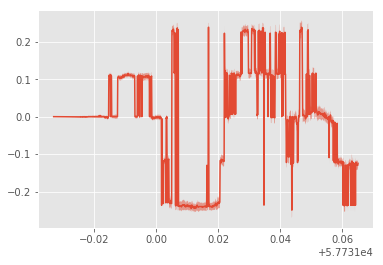

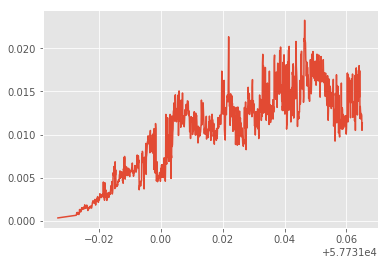

In [59]:
%matplotlib inline
from bayes_tec.datapack import DataPack
from bayes_tec.plotting.plot_datapack import plot_data_vs_solution
import numpy as np
with DataPack('../../scripts/data/killms_datapack_2.hdf5',readonly=True) as datapack:
    datapack.select(time=slice(0,1000,1),ant='RS210HBA',pol=slice(0,1,1))
    tec, axes = datapack.tec
    tec_weights, _ = datapack.weights_tec
    tec_std = 1./np.sqrt(tec_weights)
    phase, axes = datapack.phase
    
    _, freqs = datapack.get_freqs(axes['freq'])
    tec_conv = -8.448e9/freqs
    
    phase_pred = tec[...,None,:]*tec_conv[:,None]
    
    def wrap (phi):
        return np.angle(np.exp(1j*phi))
    
    dphase = wrap(wrap(phase_pred) - wrap(phase))
    tec_std = np.percentile(np.abs(dphase / tec_conv[:,None]),50,axis=-2)
    
    _,times = datapack.get_times(axes['time'])

import pylab as plt
plt.plot(times.mjd, tec[0,0,0,:])
plt.fill_between(times.mjd, tec[0,0,0,:]-tec_std[0,0,0,:],tec[0,0,0,:]+tec_std[0,0,0,:],alpha=0.5)
plt.show()
plt.plot(times.mjd, tec_std[0,0,0,:])
plt.show()

In [75]:
X = times.mjd[:,None]*86400.
X -= X.min()
Y = tec[0,0,0,:][:,None]
Y_var = tec_std[0,0,0,:][:,None]
from bayes_tec.models.heteroscedastic_tec_svgp import HeteroscedasticTecSVGP
from bayes_tec.likelihoods import GaussianTecHetero
import gpflow as gp
import tensorflow as tf

with tf.Session(graph=tf.Graph()) as sess:

    Z = X
    q_mu = Y/0.005#M, 1
    q_sqrt = np.diag(np.sqrt(Y_var[:,0]))[None,:,:]/0.005#1, M, M
    with gp.defer_build():
        likelihood = GaussianTecHetero(tec_scale=0.005)
        kern = gp.kernels.RBF(1)
        kern.lengthscales = 25.
        model = HeteroscedasticTecSVGP(Y_var, X, Y, kern=kern,likelihood=likelihood, Z=Z, q_mu = q_mu, q_sqrt = q_sqrt)
        model.compile()
        
    lik = model.likelihood_tensor
    logp = likelihood.logp(X,Y,Y_var)
    liks = []
    l_array = np.linspace(8,200,100)
    for l in l_array:
        kern.lengthscales = l
        model.compile()
        liks.append(model.compute_log_likelihood())#sess.run( lik))
    logp_ = sess.run(logp)
    ystar, varstar = model.predict_dtec(X)

#     print(logp_)
    


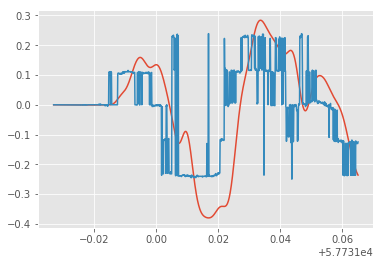

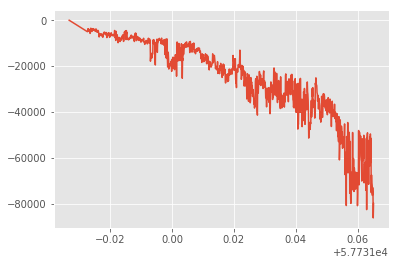

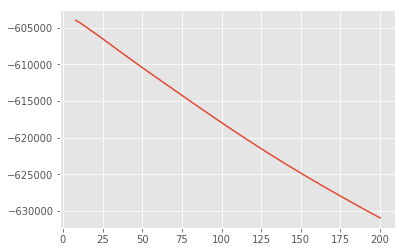

In [76]:
plt.plot(times.mjd,ystar[:,0]/5.)
plt.plot(times.mjd,Y[:,0])
plt.show()
plt.plot(times.mjd,logp_.flatten())
plt.show()
plt.plot(l_array,liks)
plt.show()

2018-10-01 12:40:14,000 Shape of x must be 2D at computation.


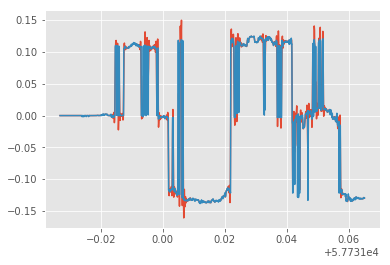

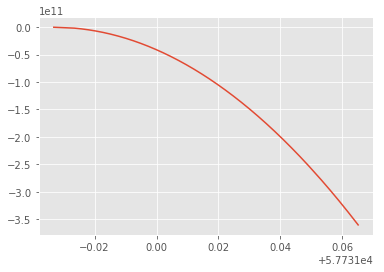

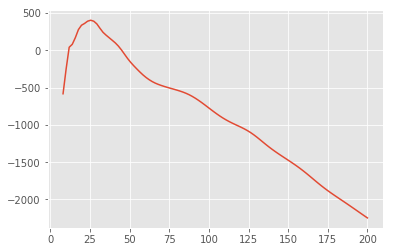

In [44]:
X = times.mjd[:,None]*86400.
X -= X.min()
Y = tec[0,0,0,:][:,None]
Y_var = tec_std[0,0,0,:][:,None]
from bayes_tec.models.heteroscedastic_tec_svgp import HeteroscedasticTecSVGP
from bayes_tec.likelihoods import GaussianTecHetero
import gpflow as gp
import tensorflow as tf

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        kern = gp.kernels.RBF(1)
        
        model = gp.models.GPR(X,Y,kern)
        model.compile()
    kern.lengthscales = 25.
    model.likelihood.variance = 0.01**2
        
    lik = model.likelihood_tensor
    logp = model.likelihood.logp(X,Y)
    
    logp_ = sess.run(logp)
    ystar, varstar = model.predict_f(X)
    
    liks = []
    l_array = np.linspace(8,200,100)
    for l in l_array:
        kern.lengthscales = l
        model.compile()
        liks.append(model.compute_log_likelihood())#sess.run( lik))
    
#     print(logp_)

plt.plot(times.mjd,ystar[:,0])
plt.plot(times.mjd,Y[:,0])
plt.show()
plt.plot(times.mjd,logp_.flatten())
plt.show()
plt.plot(l_array,liks)
plt.show()

In [ ]:
plot_data_vs_solution(datapack,'figs',solution_solset='sol000',time_sel=slice(0,100,1),ant_sel='RS210HBA',pol_sel=slice(0,1,1))

In [ ]:
import numpy as np
tec_std = 1./np.sqrt(tec_weights)
phase_std = 1./np.sqrt(phase_weights)

In [ ]:
import pylab as plt
plt.style.use('ggplot')

phase_pred = tec[...,None,:]*(-8.4480e9/freqs[:,None])
phase_error = np.sqrt(np.mean((phase-phase_pred)**2,axis=-2))
               

plt.plot(times.mjd, phase[0,0,0,-3,:])
plt.plot(times.mjd, phase_pred[0,0,0,-3,:])
plt.show()

plt.plot(times.mjd, phase_std[0,0,0,-3,:]*180/np.pi,label='phase_std')
plt.plot(times.mjd, phase_error[0,0,0,:]*180/np.pi,label='phase_error')
plt.legend()
plt.show()

plt.plot(times.mjd, tec[0,0,0,:])
plt.show()

plt.plot(times.mjd, tec_std[0,0,0,:])
plt.show()



2018-10-02 15:11:02,871 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-10-02 15:11:02,881 Closing table.
2018-10-02 15:11:02,884 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-10-02 15:11:02,940 Closing table.
2018-10-02 15:11:02,946 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-10-02 15:11:02,985 Using 25 inducing points to sparsely model 1000 data points
2018-10-02 15:11:02,987 Number of latents L=Na=1, number of outputs P=Na*Npol=1
2018-10-02 15:11:02,988 Performing minibatching with 32 sized batches
2018-10-02 15:11:02,989 Kuu: 1x25x25 [0.00 MB]
2018-10-02 15:11:02,990 Kuf: 1x25x32 [0.01 MB]
2018-10-02 15:11:02,991 Kff: 1x32x32 [0.01 MB]
2018-10-02 15:11:02,992 Calculating coordinates for sol000/phase
2018-10-02 15:11:03,024 Calculating data for sol000/phase
2018-10-02 15:11:03,097 Creating temporary data source file: /net/lofar1/data1/albert

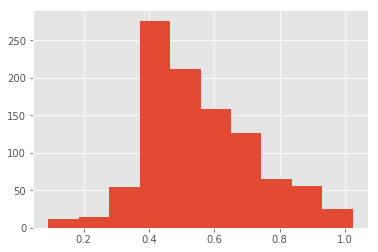

In [4]:
from bayes_tec.solvers.phase_only_solver import PhaseOnlySolver
from bayes_tec.datapack import DataPack
import numpy as np
import pylab as plt
%matplotlib inline
    
def test_get_coords():
    
    datapack = DataPack('../../scripts/data/killms_datapack_3.hdf5', readonly=True)
    with datapack:
        datapack.select(time=slice(0,1000,1),
                        ant='RS210HBA',
                        dir=slice(30,31,1),
                        pol=slice(0,1,1))

        phase, axes = datapack.phase

        _,times = datapack.get_times(axes['time'])
        _, directions = datapack.get_sources(axes['dir'])
        _, freqs = datapack.get_freqs(axes['freq'])
        Nt, Nd, Nf = len(times), len(directions), len(freqs)
        
        indices = np.array([np.random.randint(Nd,size=1000),
                    np.random.randint(Nf,size=1000),
                   np.random.randint(Nt,size=1000)]).T

        ra = directions.ra.deg[indices[:,0]]
        dec = directions.dec.deg[indices[:,0]]
        time = times.mjd[indices[:,2]]*86400. - times[0].mjd*86400.
        freq = freqs[indices[:,1]]
        
        phase = phase[0,indices[:,0],0,indices[:,1], indices[:,2]][...,None]
        
        
    
    
    solver = PhaseOnlySolver('run_dir_diagnostic', datapack)
    kwargs = {'ant_sel':"RS210HBA",
              'time_sel':slice(0,1000,1),
              'dir_sel':slice(30,31,1),
              'pol_sel':slice(0,1,1), 
              'reweight_obs':False, 
              'coord_file':"coords.hdf5",
              'minibatch_size':32, 
              'tec_scale':0.005}
    solver.output_solset = 'posterior_sol'
    solver.output_screen_solset = 'screen_sol'
    data_shape, build_params = solver._prepare_data(datapack,**kwargs)
    yv, f, x, y = solver._get_data(indices, [Nd, Nf, Nt])
    
#     plt.scatter(f,freq)
#     plt.show()
#     plt.scatter(phase.flatten(), y.flatten())
#     plt.show()
#     plt.scatter(ra, x[:,0])
#     plt.show()
#     plt.scatter(dec, x[:,1])
#     plt.show()
#     plt.scatter(time, x[:,2])
#     plt.show()
    plt.hist((np.sqrt(yv.flatten())))
    plt.show()
    
    assert np.isclose(ra, x[:,0]).all()
    assert np.isclose(dec, x[:,1]).all()
    assert np.isclose(time, x[:,2]).all()
    assert np.isclose(phase, y).all()
    assert np.isclose(freq, f[:,0]).all()
    assert np.all(yv < 2*np.pi)
    
    
    
    
test_get_coords()

In [4]:

from bayes_tec.utils.data_utils import make_coord_array
import numpy as np

def test_make_coord_array():
    a,b,c,d = np.random.normal(size=[4,10])
    a,b,c,d = a[:,None],b[:,None],c[:,None],d[:,None]
    X1 = make_coord_array(a,b,c,d,flat=True)
    X2 = make_coord_array(a,b,c,d,flat=False)

    idx = np.ravel_multi_index([1,2,3,4],[10,10,10,10])

    assert np.all(X2[1,2,3,4,:] == np.array([a[1],b[2],c[3],d[4]]).flatten())
    assert np.all(X1[idx,:] == X2[1,2,3,4,:])
    
    a = np.random.normal(size=[10,2])
    b = np.random.normal(size=[10,1])
    
    X1 = make_coord_array(a,b,flat=True)
    X2 = make_coord_array(a,b,flat=False)

    idx = np.ravel_multi_index([1,2],[10,10])

    assert np.all(X2[1,2,:2] == a[1])
    assert np.all(X2[1,2,2:3] == b[2])
    assert np.all(X1[idx,:] == X2[1,2,:])
    
    ###
    # no freq test
    a = np.random.normal(size=[10,2])
    b = np.random.normal(size=[10,1])
    c = np.random.normal(size=[10,1])
    X1 = make_coord_array(a,b,c,flat=True)[..., [0,1, 3]]
    X2 = make_coord_array(a,b,c,flat=False)[..., [0,1, 3]]

    idx = np.ravel_multi_index([1,2,3],[10,10,10])

    assert np.all(X1[idx,:] == X2[1,:,3,:])
    
    

    
test_make_coord_array()

(1000, 3) (10, 10, 10, 3)
[-0.97317908  2.22972273  0.13678183] [[-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]
 [-0.97317908  2.22972273  0.13678183]]


In [7]:
from bayes_tec.solvers.phase_only_solver import PhaseOnlySolver
from bayes_tec.datapack import DataPack
import tensorflow as tf
import numpy as np
from tensorflow_probability import math

datapack = '../../scripts/data/killms_datapack_3.hdf5'
datapack = DataPack(datapack)
solver = PhaseOnlySolver('run_dir_prior_test', datapack)

kwargs = {'ant_sel':slice(51,52,1),
          'time_sel':slice(1,20,1),
          'pol_sel':slice(0,1,1), 
          'reweight_obs':False, 
          'dof_ratio':1,
          'coord_file':"coords.hdf5",
          'minibatch_size':512, 
          'tec_scale':0.005,
         "priors":{"kern_time_ls":25.,
                   "kern_dir_ls":0.5}}

solver.output_solset = 'posterior_sol'
solver.output_screen_solset = 'screen_sol'
data_shape, build_params = solver._prepare_data(datapack,**kwargs)



with tf.Session(graph=tf.Graph()) as sess:
    _, data_tensors = solver._train_dataset_iterator(data_shape, sess=sess,**kwargs)
    model = solver._build_model(*data_tensors, **build_params, **kwargs)
    liks = []
    l_array = np.linspace(8,75,20)
    for l in l_array:
        model.kern.kernels[0].kernels[1].lengthscales = l
        model.compile()
        liks.append(model.compute_log_likelihood())
#     print(list(sess.run(model.Y_var.parameter_tensor/model.Y.parameter_tensor)))
#     lik_1 = [model.compute_log_likelihood() for i in range(10)]

2018-10-01 18:25:33,685 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-10-01 18:25:33,692 Closing table.
2018-10-01 18:25:33,696 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-10-01 18:25:33,725 Using 855 inducing points to sparsely model 855 data points
2018-10-01 18:25:33,727 Number of latents L=Na=1, number of outputs P=Na*Npol=1
2018-10-01 18:25:33,728 Performing minibatching with 512 sized batches
2018-10-01 18:25:33,729 Kuu: 1x855x855 [5.58 MB]
2018-10-01 18:25:33,730 Kuf: 1x855x512 [3.34 MB]
2018-10-01 18:25:33,731 Kff: 1x512x512 [2.00 MB]
2018-10-01 18:25:33,731 Calculating coordinates for sol000/phase
2018-10-01 18:25:33,749 Calculating data for sol000/phase
2018-10-01 18:25:33,819 Creating temporary data source file: /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/run_dir_prior_test/run_027/data_source_45f80ca4-b055-4049-a4b0-cbf92813e3da.hdf5
2018-10-01 18:25:33,826 Initializ

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargs

In [8]:
liks

[-22560.555446038838,
 -18960.01817543578,
 -28446.98704140469,
 -19756.72588225461,
 -13938.326186463637,
 -21282.493932055113,
 -16451.005334243124,
 -16437.48842931512,
 -12545.880296004627,
 -17307.537346139976,
 -20116.305150314492,
 -15439.422796598225,
 -17507.341705869007,
 -20418.568967224383,
 -25580.051917937257,
 -27789.71639661744,
 -13758.57275204044,
 -18692.49349422589,
 -10507.889409519394,
 -15913.146694055988]

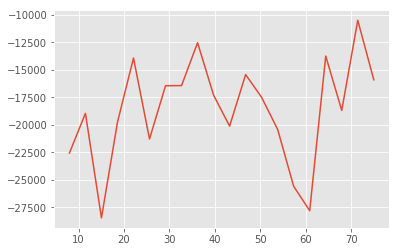

In [9]:
%matplotlib inline
import pylab as plt
plt.plot(l_array,liks)
plt.show()